In [1]:
#Importing necessary libraries 
import tensorflow as tf
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
#Defining the class labels (benign and malignant) and the desired image size (96x96).
labels = ['benign','malignant'] #i didn't add the 'normal' label because it's already filled with zeros, it's not necessary.
img_size = 96

In [3]:
#Configuring GPU memory growth to avoid GPU memory allocation issues.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#Loading images from the dataset folder, resizing them, and storing them in X_train.
#Storing corresponding class labels in y_train.

X_train = []
y_train = []

for i in labels:
    path = os.path.join('dataset',i)
    for j in os.listdir(path):
        img = cv2.imread(os.path.join(path,j))
        img = cv2.resize(img,(img_size,img_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


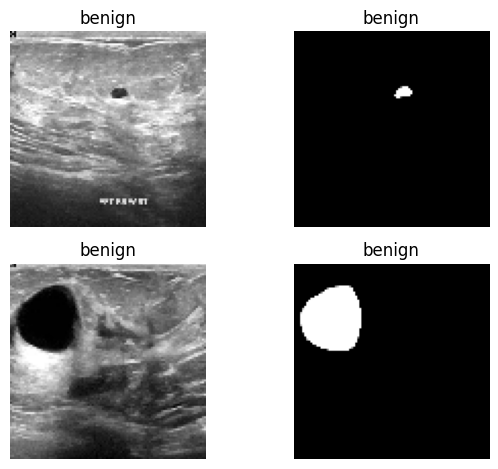

In [5]:
import matplotlib.pyplot as plt

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.axis('off')  # Turn off axis labels
plt.tight_layout()
plt.show()

In [6]:
#Normalizing the pixel values of images to the range [0, 1].
X_train = X_train / 255.0

In [8]:
from sklearn.preprocessing import LabelEncoder
#Splitting the data into training and testing sets using train_test_split.
#Encoding class labels into numerical values using LabelEncoder.
#Converting class labels to one-hot encoded vectors using to_categorical.

x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.1,random_state=20)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [11]:
#Defining a function make_model to create the model with transfer learning from the EfficientNetV2S model.
#Adding a global average pooling layer and a dropout layer to the base model.
#Adding a dense (fully connected) layer with softmax activation for classification.
def make_model(input_shape,num_classes):
    base_model = tf.keras.applications.EfficientNetV2S(include_top=False,weights="imagenet",input_shape=input_shape)
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(0.4)(model)
    model = tf.keras.layers.Dense(units=num_classes,activation="softmax")(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs = model)
    return model
    

In [12]:
#Creating an instance of the model using make_model.

input_shape = (96,96,3)
num_classes = len(labels)
model = make_model(input_shape=input_shape,num_classes=num_classes)


In [14]:
# Create lists to track loss and accuracy history before compiling the model
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Track loss and accuracy metrics during the training process
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss.append(logs["loss"])
        train_accuracy.append(logs["accuracy"])
        val_loss.append(logs["val_loss"])
        val_accuracy.append(logs["val_accuracy"])

In [15]:
#Compiling the model with Adam optimizer, categorical cross-entropy loss, and accuracy metrics.
#Performing model training using fit method, and storing loss and accuracy history using a custom callback.
epochs = 10
batch_size=36

callbacks = [
    keras.callbacks.ModelCheckpoint("weightsforbreastCancer5/save_path_{epoch}.keras",save_best_only=True),
    CustomCallback()
]

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics = ["accuracy"])
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/10
33/33 [==============================] - 19s 241ms/step - loss: 0.5066 - accuracy: 0.7729 - val_loss: 0.5235 - val_accuracy: 0.7576
Epoch 2/10
33/33 [==============================] - 5s 148ms/step - loss: 0.3020 - accuracy: 0.8703 - val_loss: 0.6035 - val_accuracy: 0.8485
Epoch 3/10
33/33 [==============================] - 6s 184ms/step - loss: 0.2696 - accuracy: 0.9068 - val_loss: 0.3677 - val_accuracy: 0.8712
Epoch 4/10
33/33 [==============================] - 5s 148ms/step - loss: 0.1586 - accuracy: 0.9441 - val_loss: 0.3927 - val_accuracy: 0.8561
Epoch 5/10
33/33 [==============================] - 6s 186ms/step - loss: 0.1380 - accuracy: 0.9432 - val_loss: 0.3155 - val_accuracy: 0.9242
Epoch 6/10
33/33 [==============================] - 6s 199ms/step - loss: 0.1222 - accuracy: 0.9610 - val_loss: 0.2484 - val_accuracy: 0.9091
Epoch 7/10
33/33 [==============================] - 5s 148ms/step - loss: 0.0751 - accuracy: 0.9712 - val_loss: 0.4561 - val_accuracy: 0.8561
Epoch

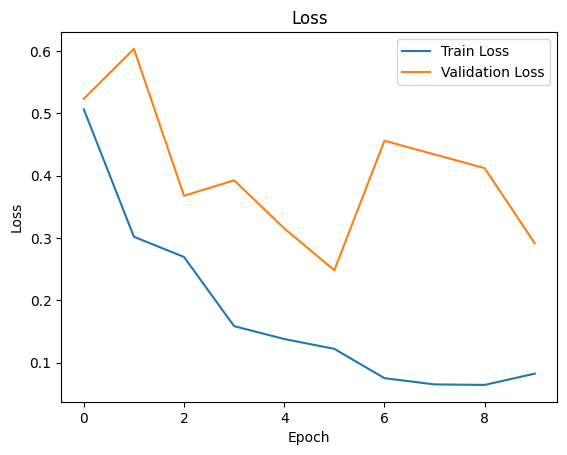

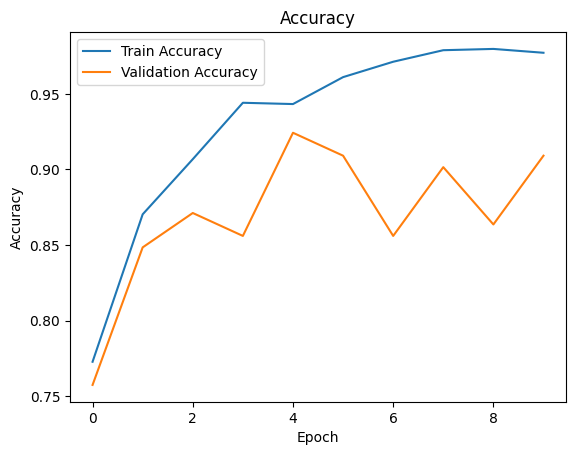

In [16]:
import matplotlib.pyplot as plt
#Plotting the training and validation loss curves using matplotlib.

# Plot the loss curve
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


5/5 [==============================] - 2s 55ms/step


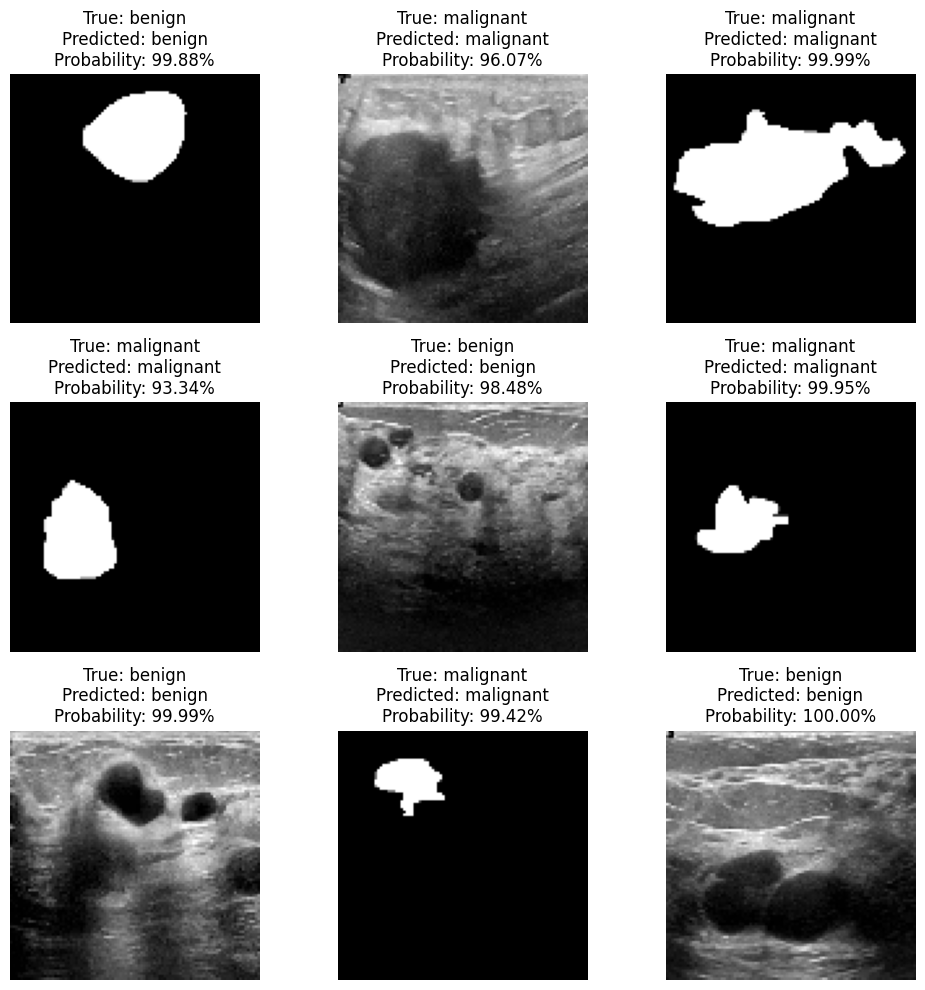

In [17]:
import matplotlib.pyplot as plt

# Assuming pred is the predicted values from the model
# and x_test contains the corresponding images
pred = model.predict(x_test)
# Convert one-hot encoded predicted values to class labels
pred_labels = np.argmax(pred, axis=1)

# Get the class names
class_names = le.classes_

# Plot the images with predicted labels and probabilities
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i])
    ax.axis('off')
    true_label = class_names[np.argmax(y_test[i])]
    pred_label = class_names[pred_labels[i]]
    pred_prob = pred[i][pred_labels[i]] * 100
    ax.set_title(f'True: {true_label}\nPredicted: {pred_label}\nProbability: {pred_prob:.2f}%')
plt.tight_layout()
plt.show()
